In [ ]:
from math import sqrt 
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
import json

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, accuracy_score
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K

%matplotlib inline

#Funciones

In [ ]:
def helada(row):
  if row['Y'] <= 0:
    return 0
  else: 
    return 1 

In [ ]:
def plot_historylr(histo, epochs):
  hist= histo
  hist['epoch'] = range(epochs)

  pyplot.figure(figsize=(5, 5))
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],  label='Entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Validación')
  plt.legend()
  plt.show()

#Parámetros

In [ ]:
look_back=18
col=['LowTemp','OutHum','DewPt']
colnames= []

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Preprocesamiento

In [ ]:
for i in range(look_back): 
  for s in col:
    colnames.append(s+str(i+1))

cantCaract= len(colnames)

colnames.append("Y")
colnames.append("DateTime")

In [ ]:
df_inta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosINTA_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_inta['DateTime'] = pd.to_datetime(df_inta['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_inta= df_inta.sort_values(by='DateTime')

In [ ]:
df_sf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosSF_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_sf['DateTime'] = pd.to_datetime(df_sf['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_sf= df_sf.sort_values(by='DateTime')

In [ ]:
col_num= colnames[:cantCaract+1]
for c in col_num:
  df_inta[c].mask(df_inta[c] == '---',0,inplace=True)
  df_inta[c]= pd.to_numeric(df_inta[c])
  df_sf[c].mask(df_sf[c] == '---',0,inplace=True)
  df_sf[c]= pd.to_numeric(df_sf[c])

#**Conjunto de entrenamiento y de test**

In [ ]:
df_sftrain= df_sf[df_sf.DateTime.dt.year <= 2017]
df_sfval= df_sf[df_sf.DateTime.dt.year > 2017]
df_test= df_inta

print('total de reg: {} 70% del total {} 30% del total {}'.format(len(df_sf),len(df_sf)*0.7,len(df_sf)*0.3))
print('total train {} total val {}'.format(len(df_sftrain),len(df_sfval)))
print(' porcentaje que representa los datos para train respecto del total SF: {}'.format(len(df_sftrain) *100/ len(df_sf)))

total de reg: 61011 70% del total 42707.7 30% del total 18303.3
total train 44203 total val 16808
 porcentaje que representa los datos para train respecto del total SF: 72.4508695153333


In [ ]:
xtrain= df_sftrain.iloc[:,0:cantCaract]
ytrain= df_sftrain.loc[:,'Y']
xval= df_sfval.iloc[:,0:cantCaract]
yval= df_sfval.loc[:,'Y']
xtest= df_test.iloc[:,0:cantCaract]
ytest= df_test.loc[:,'Y']

#** estandariza features**

In [ ]:
scalerX = StandardScaler()
scalerY = StandardScaler()

dataX= pd.concat([xtrain, xval, xtest], axis=0)
dataY= pd.concat([ytrain, yval, ytest], axis=0)

dataX= dataX.to_numpy()
print('----------X---------')
print(scalerX.fit(dataX.astype('float32')))
print('-------------------')
print(scalerX.mean_)
print(len(scalerX.mean_))

dataY= dataY.to_numpy().reshape(-1,1)
print('----------Y---------')
print(scalerY.fit(dataY.astype('float32')))
print('-------------------')
print(scalerY.mean_)

----------X---------
StandardScaler()
-------------------
[ 8.05173821 65.21695241  1.05407454  7.83913564 65.79199775  1.01613729
  7.62931206 66.3552535   0.97613901  7.42457462 66.90063051  0.93375043
  7.22743026 67.42491147  0.89049274  7.04004362 67.92389661  0.84723074
  6.86409678 68.39421748  0.8042354   6.70045129 68.8337148   0.76196234
  6.548929   69.24258292  0.72065555  6.40897284 69.62254923  0.68083002
  6.27932501 69.97537355  0.64206577  6.15857877 70.30387373  0.60478926
  6.04538996 70.61323199  0.5691635   5.93831296 70.90723786  0.53463789
  5.83617205 71.18830973  0.50133335  5.73800203 71.4581426   0.46839156
  5.64316916 71.7193384   0.43606085  5.55090689 71.9737649   0.4040821 ]
54
----------Y---------
StandardScaler()
-------------------
[4.42810071]


In [ ]:
trainX_scaler= scalerX.transform(xtrain.to_numpy())
trainY_scaler= scalerY.transform(ytrain.to_numpy().reshape(-1,1))
validationX_scaler= scalerX.transform(xval.to_numpy())
validationY_scaler= scalerY.transform(yval.to_numpy().reshape(-1,1))
testX_scaler= scalerX.transform(xtest.to_numpy())
testY_scaler= scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [ ]:
print(trainX_scaler.shape, trainY_scaler.shape)
print(validationX_scaler.shape, validationY_scaler.shape)
print(testX_scaler.shape, testY_scaler.shape)

(44203, 54) (44203, 1)
(16808, 54) (16808, 1)
(31613, 54) (31613, 1)


In [ ]:
trainX_scaler = np.reshape(trainX_scaler, (trainX_scaler.shape[0], look_back, len(col)))
validationX_scaler = np.reshape(validationX_scaler, (validationX_scaler.shape[0], look_back, len(col)))
testX_scaler = np.reshape(testX_scaler, (testX_scaler.shape[0], look_back, len(col)))

#Entrenamiento

In [ ]:
#import keras.optimizers.Adam
import tensorflow as tf

def modelo(n_time_step, n_features, neuron, lr):
  model = Sequential()
  #input_shape=(time_steps,feachures)
  model.add(LSTM(neuron, activation= "relu",input_shape=(n_time_step, n_features)))  
  model.add(Dense(1))
  model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mse'])  
  model.summary()
  return model

In [ ]:
neurons=[18*len(col)]
num_epochs = [70]
learning_rates = [1E-3, 1E-4, 1E-5, 1E-6]
cantidad_modelos= len(learning_rates)
models = []
histories=[]

# pruebas con [1E-3, 1E-4, 1E-5, 1E-6]


In [ ]:
# create learning curves for different learning rates

for i in range(len(learning_rates)):  
  model = modelo(look_back,len(col),neurons[0],learning_rates[i])
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[0], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  histories.append(pd.DataFrame(history.history))
  models.append(model)
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  model.reset_states() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 54)                12528     
                                                                 
 dense (Dense)               (None, 1)                 55        
                                                                 
Total params: 12,583
Trainable params: 12,583
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  965.9197766780853
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 54)                12528     
                                                                 
 dense_1 (Dense)             (None, 1)                 55        
                                                 

In [ ]:
learning_rates.append(8E-7)
cantidad_modelos= len(learning_rates)


In [ ]:
learning_rates2 = [8E-7]
for i in range(len(learning_rates2)):
  model = modelo(look_back,len(col),neurons[0],learning_rates2[i])
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[0], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  histories.append(pd.DataFrame(history.history))
  models.append(model)
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  model.reset_states() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 54)                12528     
                                                                 
 dense (Dense)               (None, 1)                 55        
                                                                 
Total params: 12,583
Trainable params: 12,583
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  875.0666489601135


In [ ]:
learning_rates += learning_rates2
print(learning_rates)
cantidad_modelos= len(learning_rates)

[0.001, 0.0001, 1e-05, 1e-06, 8e-07]


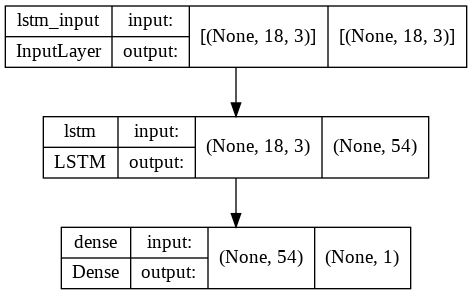

In [ ]:
tf.keras.utils.plot_model(models[0], show_shapes=True)

In [ ]:
#learning_rates = [1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
i=0
for h in histories:
  print(learning_rates[i])
  plot_historylr(h, num_epochs[0])
  i+=1

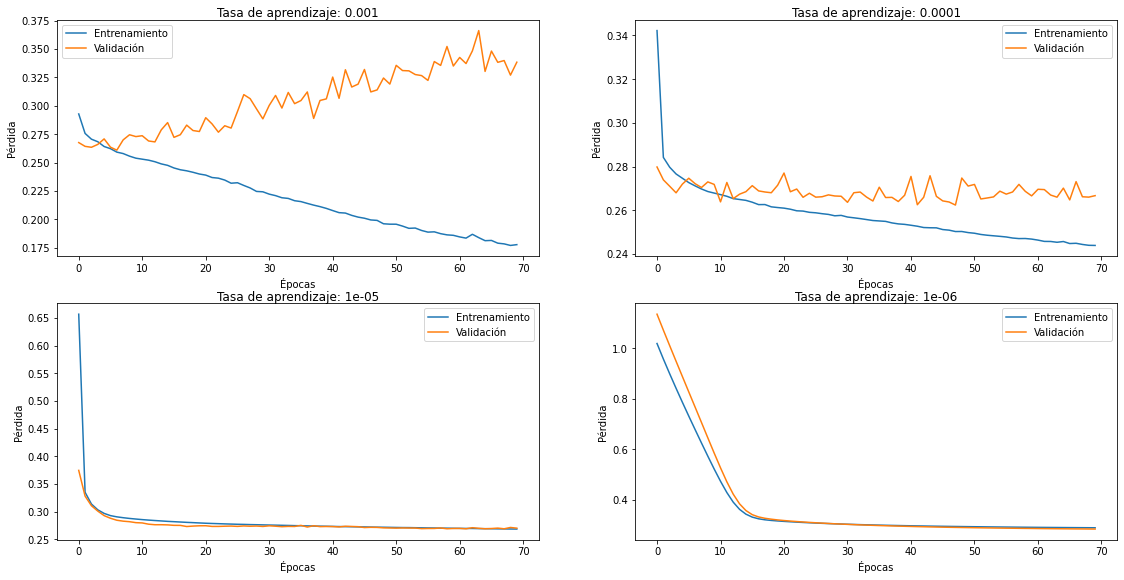

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Tasa de aprendizaje: '+str(learning_rates[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

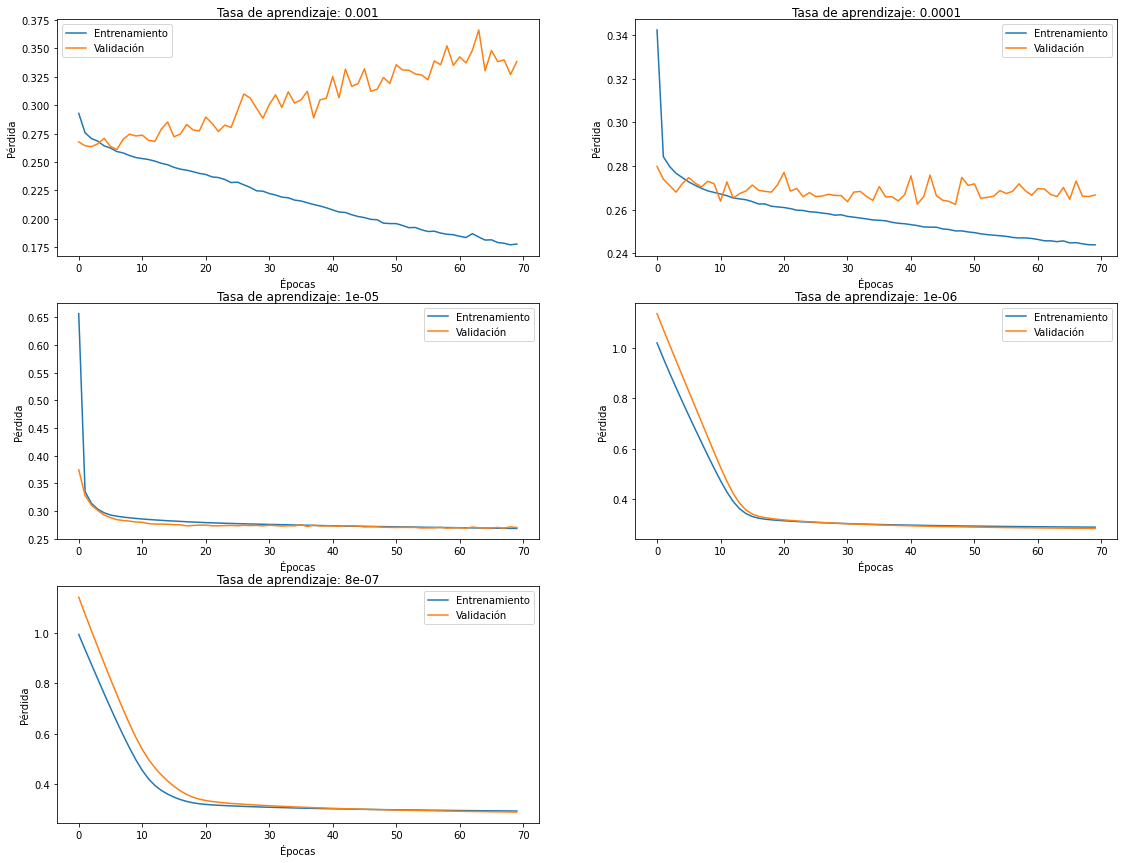

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Tasa de aprendizaje: '+str(learning_rates[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

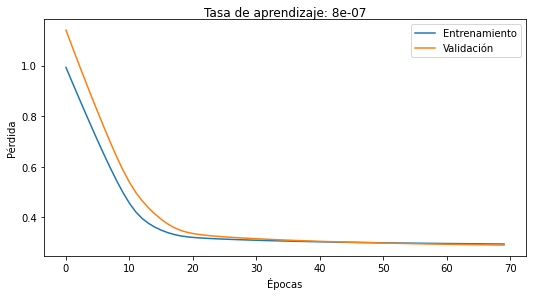

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
h= histories[4]
plot_no = 420 + (i+1)
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento')
plt.plot(h['val_loss'], label='Validación')
plt.title('Tasa de aprendizaje: '+str(learning_rates[4]), pad=-50)	
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
pyplot.figure(figsize=(5, 5))

In [ ]:
print("lr loss entrenamiento loss validacion")
i=0
for h in histories:  
  print("{:6} {:7.4f}      {:7.4f}".format(learning_rates[i],h["loss"].iloc[-1], h['val_loss'].iloc[-1]))
  i+=1

lr loss entrenamiento loss validacion
 0.001  0.1778       0.3385
0.0001  0.2440       0.2667
 1e-05  0.2687       0.2703
 1e-06  0.2905       0.2854
 8e-07  0.2945       0.2905


           0.001     0.0001      1e-05      1e-06      8e-07
count  70.000000  70.000000  70.000000  70.000000  70.000000
mean    0.219102   0.257688   0.283284   0.374061   0.374387
std     0.029268   0.013848   0.046587   0.173702   0.163157
min     0.177053   0.243965   0.268682   0.290491   0.294529
25%     0.192804   0.248722   0.271345   0.294129   0.298823
50%     0.216060   0.255262   0.274775   0.301260   0.306396
75%     0.242466   0.262384   0.280665   0.321385   0.331088
max     0.292873   0.342232   0.656858   1.018895   0.993039


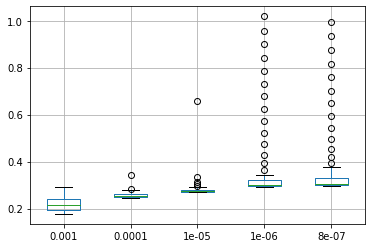

In [ ]:
results = pd.DataFrame()
i=0
for h in histories:
  results[str(learning_rates[i])]= h['loss']
  i+= 1
print(results.describe())
	
results.boxplot()

           1e-06      8e-07
count  70.000000  70.000000
mean    0.374061   0.374387
std     0.173702   0.163157
min     0.290491   0.294529
25%     0.294129   0.298823
50%     0.301260   0.306396
75%     0.321385   0.331088
max     1.018895   0.993039


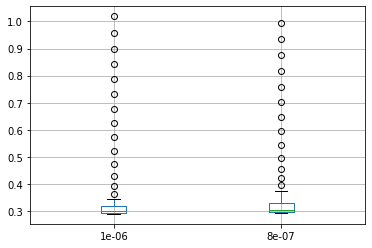

In [ ]:
results = pd.DataFrame()
i=3
hist= histories[3:]
for h in hist:
  results[str(learning_rates[i])]= h['loss']
  i+= 1
print(results.describe())
	
results.boxplot()

In [ ]:
nombreModelo= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_trivar_Lr_StandarScaler_Modelo"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


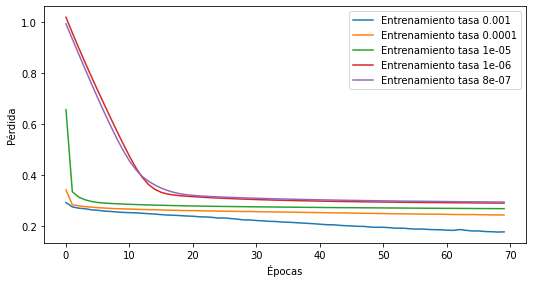

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
plot_no = 420 + (i+1)
for h in histories: 
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento tasa '+str(learning_rates[i]))
  i+= 1
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
pyplot.figure(figsize=(5, 5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


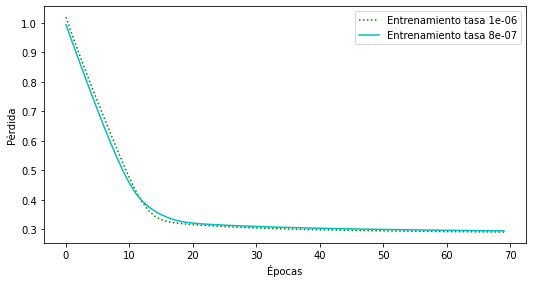

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
plot_no = 420 + (i+1)
h= histories[3] 
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento tasa '+str(learning_rates[3]), color="g", linestyle='dotted')
h= histories[4] 
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento tasa '+str(learning_rates[4]), color="c")
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
pyplot.figure(figsize=(5, 5))

#-------- GUARDA LOS MODELOS --------

In [ ]:
# serializa el modelo para JSON
for i in range(cantidad_modelos):
  model_json = models[i].to_json()
  with open(nombreModelo+str(i)+".json", "w") as json_file:
    json_file.write(model_json)
  #serializan los pesos (weights) para HDF5
  models[i].save_weights(nombreModelo+str(i)+".h5")
  # guarda el history
  histories[i].to_csv(nombreModelo+'history_'+str(i)+'.csv',  index = False, header=True)  

print("Modelos guardado en el PC")
json_file.close()

Modelos guardado en el PC


# **Recuperar los modelos**

In [ ]:
# carga el json y crea el modelo
models=[]
histories=[]

for i in range(cantidad_modelos):
  json_file = open(nombreModelo+str(i)+".json", 'r')
  loaded_model_json = json_file.read()  
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # se cargan los pesos (weights) en el nuevo modelo
  loaded_model.load_weights(nombreModelo+str(i)+".h5")
  models.append(loaded_model)
  # recupero el loss (mse) y el error (mae) de entrenamiento
  histories.append(pd.read_csv(nombreModelo+'history_'+str(i)+'.csv'))  

print("Modelos recuperados en el PC")

Modelos recuperados en el PC


#Evaluación y Predicción

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  m1_testPredict = models[i].predict(testX_scaler)
  m1_testPredict = np.asarray(m1_testPredict).reshape(-1,1)
  m_testPredict_scaled.append(m1_testPredict)
  m1_testPredict = scalerY.inverse_transform(m1_testPredict)
  m_testPredict.append(m1_testPredict) 

In [ ]:
 #obtiene el error de cada modelo para el conjunto de datos de test
error_prediction=[]
error_prediction_scaled=[]
for i in range(cantidad_modelos):    
  error_prediction_scaled.append(testY_scaler.reshape(1,-1)[0] - m_testPredict_scaled[i][:,0])
  error_prediction.append(ytest.to_numpy().reshape(1,-1)[0] - m_testPredict[i][:,0])

In [ ]:
print('Lr   se_train mse_val mse_test rmse_train rmse_val rmse_test r2_train r2_val r2_test')
for i in range(cantidad_modelos):
  trainpred= models[i].predict(trainX_scaler)  
  valpred= models[i].predict(validationX_scaler)  

  msetrain= mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  
  mseval =  mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))  
  msetest=  mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]) 

  rmsetrain= sqrt(mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  )
  rmseval=  sqrt(mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))) 
  rmsetest= sqrt(mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]))
  
  r2train= r2_score(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))
  r2val=   r2_score(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))
  r2test= r2_score(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0])

  print('{:8}{:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} '.format(learning_rates[i],msetrain, mseval, msetest, rmsetrain, rmseval,rmsetest, r2train, r2val, r2test))
  

Lr   se_train mse_val mse_test rmse_train rmse_val rmse_test r2_train r2_val r2_test
   0.001   4.816    9.334    9.327    2.195    3.055    3.054    0.838    0.729    0.529 
  0.0001   6.772    7.356    6.820    2.602    2.712    2.611    0.772    0.786    0.656 
   1e-05   7.400    7.454    6.318    2.720    2.730    2.514    0.751    0.783    0.681 
   1e-06   8.008    7.871    6.390    2.830    2.806    2.528    0.730    0.771    0.678 
   8e-07   8.119    8.010    6.439    2.849    2.830    2.538    0.727    0.767    0.675 


In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1

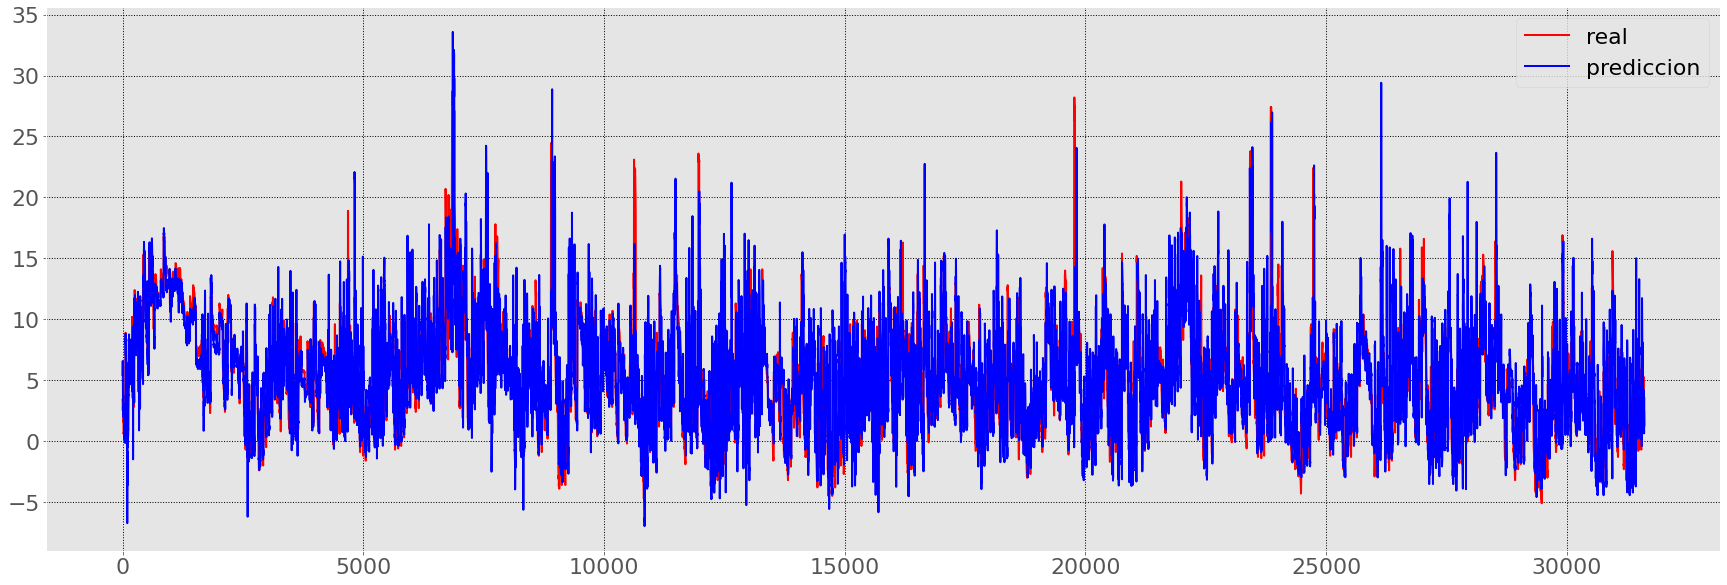

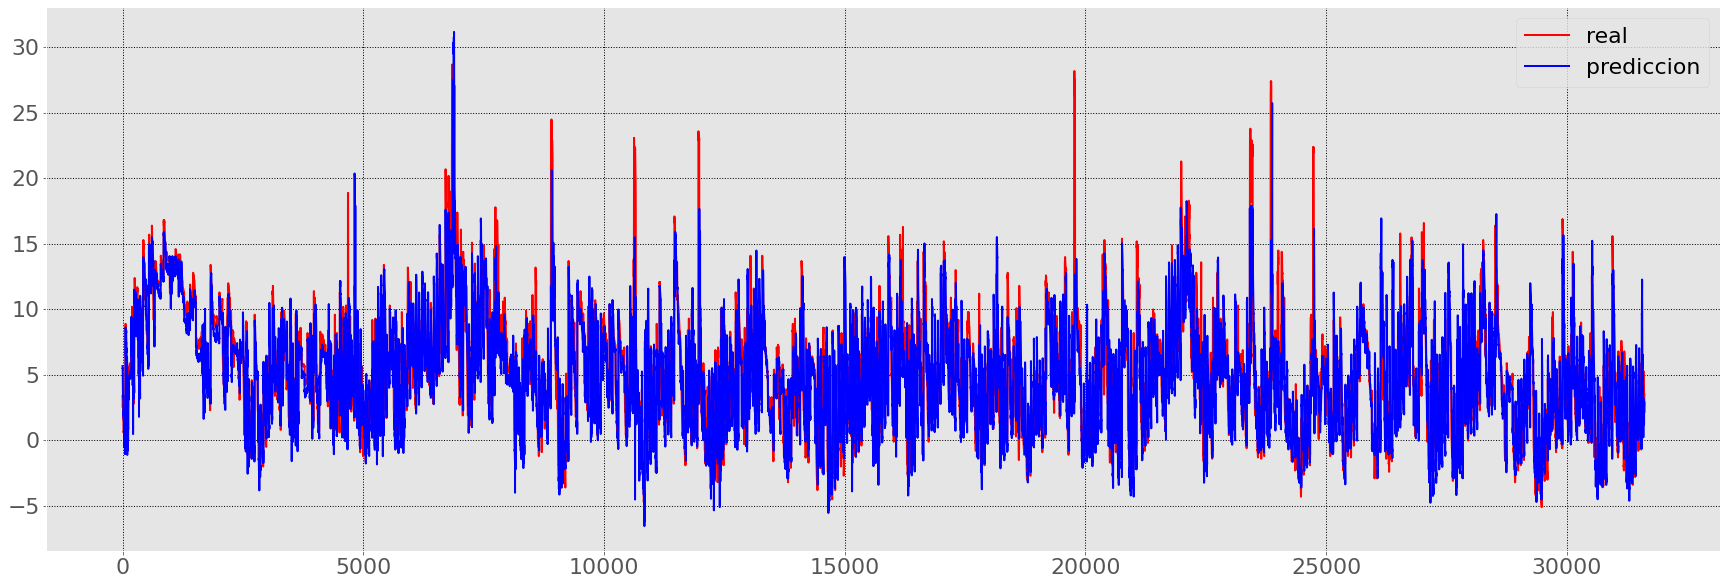

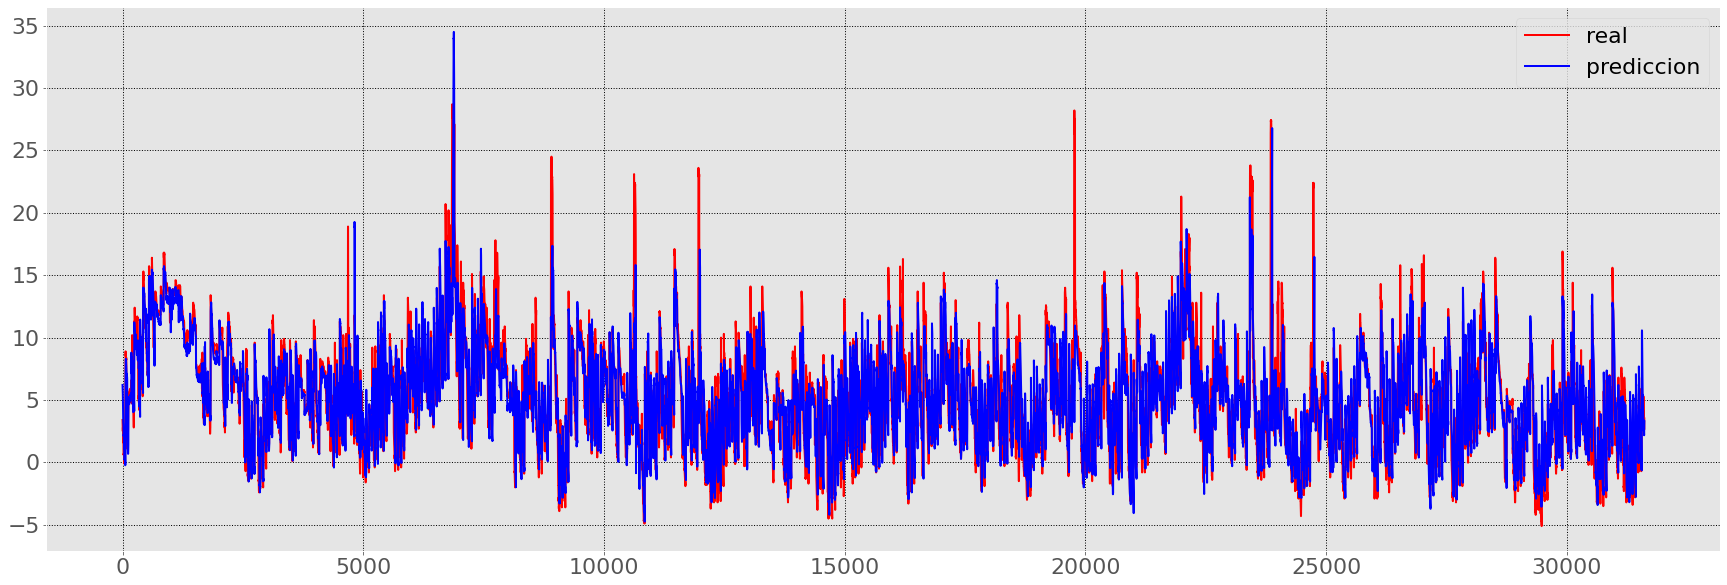

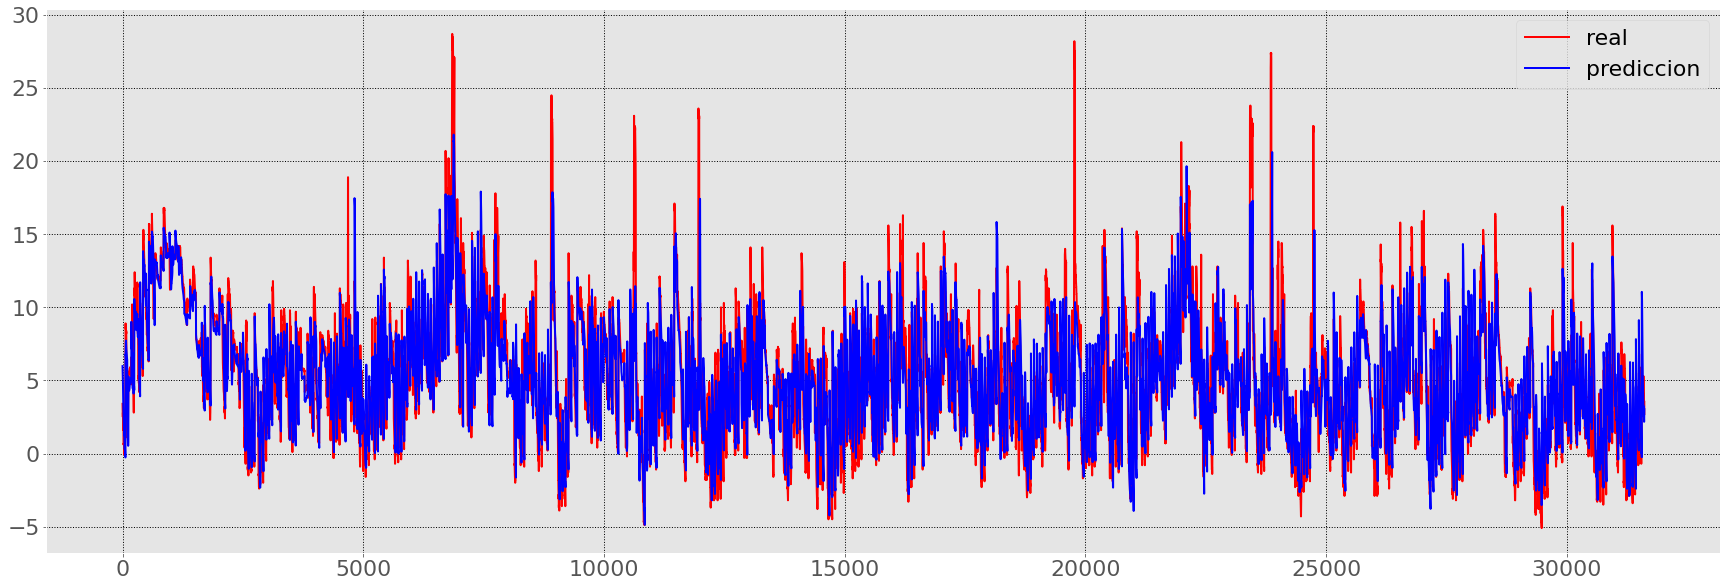

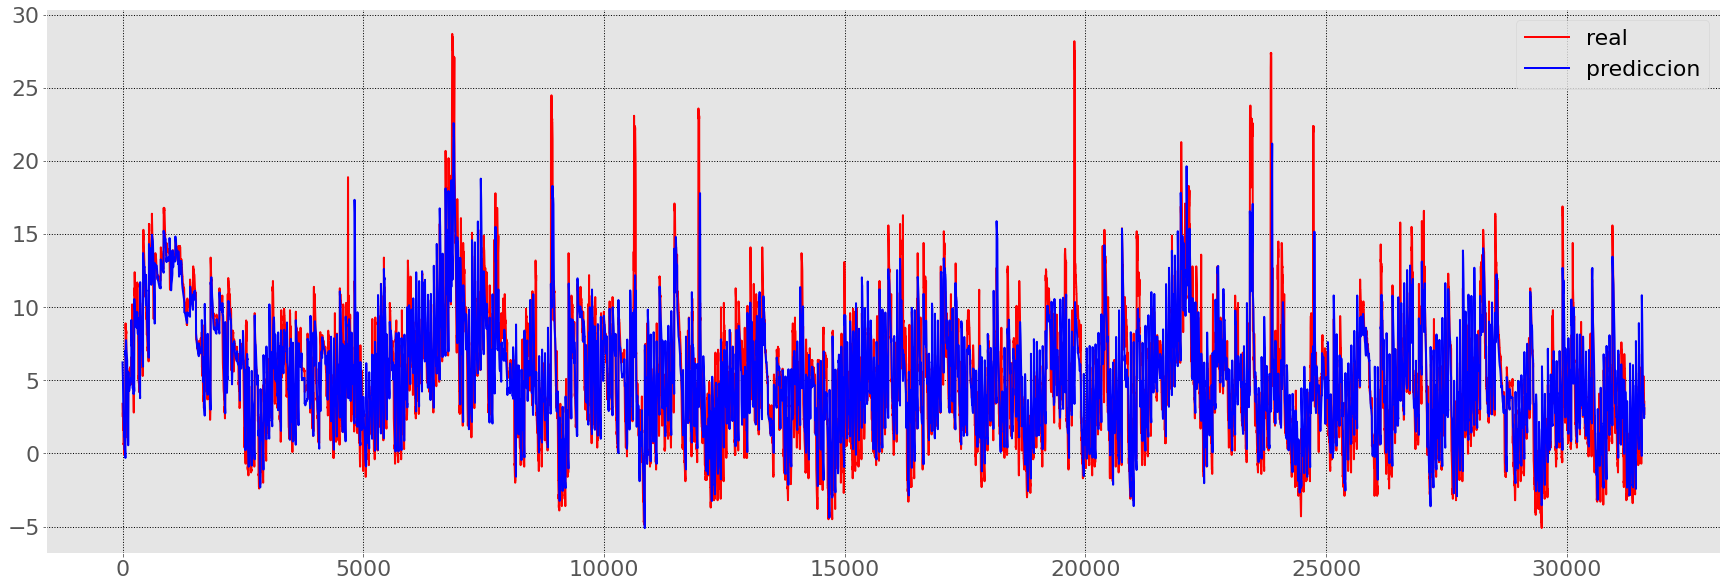

In [ ]:
for i in range(cantidad_modelos):
  plt.plot(ytest.to_numpy().reshape(1,-1)[0], color= "red", label="real")
  plt.plot(m_testPredict[i][:,0], color= "blue", label="prediccion")
  #plt.plot(error_prediction[i], color='green', label= 'error')
  plt.legend()
  plt.show()

#Helada

In [ ]:
index= ytest <= 0
ty= ytest[index]
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  print('MSE: %.4f ' % (mean_squared_error(ty, py, squared= True)))

MSE: 6.5003 
MSE: 3.9033 
MSE: 4.1505 
MSE: 4.4738 
MSE: 5.2340 


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("{:7.3f}".format(accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 

  0.913
[[ 1948  1812]
 [  925 26928]]
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      3760
           1       0.94      0.97      0.95     27853

    accuracy                           0.91     31613
   macro avg       0.81      0.74      0.77     31613
weighted avg       0.91      0.91      0.91     31613

  0.921
[[ 2319  1441]
 [ 1061 26792]]
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3760
           1       0.95      0.96      0.96     27853

    accuracy                           0.92     31613
   macro avg       0.82      0.79      0.80     31613
weighted avg       0.92      0.92      0.92     31613

  0.921
[[ 1947  1813]
 [  673 27180]]
              precision    recall  f1-score   support

           0       0.74      0.52      0.61      3760
           1       0.94      0.98      0.96     27853

    accuracy                           0.92     31613
   macro av